# Lecture 19 - A/B Testing

This notebook will show you how to perform A/B testing on Twitter data.

Below is the overview of this notebook.

<ol type = 1>
    <li> Retweet Count vs Keyword</li>
    <ol type = 1>
      <li> Z-test</li>
      <li> T-test</li>
      <li> Mann-Whitney U test</li>
      <li> Kolmogorov- Smirnov test</li>
      <li> Testing Multiple Hypotheses</li>
    </ol>
    <li> Comparing User Language</li>
    <ol type = 1>
      <li> Fisher Exact Test</li>
    </ol>
    <li> Correlation Coefficients</li>
    <ol type = 1>
         <li> Pearson Correlation Coefficient</li>
        <li> Spearman Correlation Coefficient</li>
    </ol>
    <li> Follower Engagement</li>
    <li> Tweet Time</li>

</ol>

This notebook can be opened in Colab 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zlisto/social_media_analytics/blob/main/Lecture19_ABTesting.ipynb)

Before starting, select "Runtime->Factory reset runtime" to start with your directories and environment in the base state.

If you want to save changes to the notebook, select "File->Save a copy in Drive" from the top menu in Colab.  This will save the notebook in your Google Drive.




# Clones, installs, and imports


## Clone GitHub Repository
This will clone the repository to your machine.  This includes the code and data files.  Then change into the directory of the repository.

In [ ]:
!git clone https://github.com/zlisto/social_media_analytics

import os
os.chdir("social_media_analytics")

Cloning into 'social_media_analytics'...
remote: Enumerating objects: 475, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 475 (delta 17), reused 24 (delta 6), pack-reused 435
Receiving objects: 100% (475/475), 52.54 MiB | 14.00 MiB/s, done.
Resolving deltas: 100% (249/249), done.
Updating files: 100% (56/56), done.


## Install Requirements 


In [ ]:
!pip install -r requirements.txt --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 82.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.9 MB/s eta 0:00:00
  Pr

## Import Packages



In [ ]:
from datetime import datetime, timedelta
import numpy as np
import sqlite3, sys, os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy import stats
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.multitest import multipletests

#import statsmodels.stats.multitest.multipletests as multipletests
#helper code
from scripts.api import *
import scripts.TextAnalysis as ta

pd.set_option("display.max_colwidth", None)


# Data Processing

## Load data

The data is in `"data/lec_08_tweets_sentiment.csv"`.  This contains tweets and their sentiment for several prominent Twitter users.

In [ ]:
fname = "data/lec_08_tweets_sentiment.csv"
df_all = pd.read_csv(fname)
ntweets = len(df_all)
print(f"dataframe has {ntweets} tweets")
df_all.sample(n=2)

dataframe has 8628 tweets


,Unnamed: 0,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,id,author_id,conversation_id,in_reply_to_user_id,geo,sentiment
4158,4156,2021-02-28T08:28:48.000Z,JBALVIN,RT @DiorWar: @JBALVIN @Canelo fight night 🔥🔥🔥🎶🥊🇲🇽 https://t.co/wOJXpZ04mk,en,81.0,0.0,0.0,0.0,1.365942e+18,44670915,1.365942e+18,NaN,None,3.333505
5963,5961,2021-08-11T19:05:53.000Z,AOC,"The @FairGrowthCmte is a historic temporary select committee to tackle inequality in America.\n\nIt is modeled off TNEC, (Temporary Nat’l Economic Committee) that was charged w/ investigating the extreme concentration of economic power in the US leading up to the Great Depression.",en,139.0,56.0,1414.0,5.0,1.425534e+18,138203134,1.425533e+18,138203134.0,None,3.722128


## Add keyword indicator column

We will define a list of keywords.  Then we will add a column to the dataframe called `f"keyword_{keyword}"` that tells us if the tweet contains the keyword.  

In [ ]:
keywords = ['congress','love','bill','hate']
for keyword in keywords:
  df_all[f'keyword_{keyword}'] = df_all.text.str.contains(keyword, case=False)

df_all.sample(n=2)

,Unnamed: 0,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,id,author_id,conversation_id,in_reply_to_user_id,geo,sentiment,keyword_congress,keyword_love,keyword_bill,keyword_hate
6583,6581,2021-10-14T18:21:21.000Z,KingJames,"Huge thank you to my new @TheSpringHillCo partners RedBird, @FenwaySports, @Nike, and @EpicGames. We are on a mission to empower and with this group...Imagine how many lives we can change!!! 🙏🏾✊🏾👑",en,290.0,135.0,4839.0,15.0,1.448716e+18,23083404,1.448716e+18,NaN,None,4.878761,False,False,False,False
3153,3153,2020-10-21T02:30:53.000Z,BarackObama,"One of the most inspiring things about this year has been seeing so many young people organizing, marching, and fighting for change. And to change the game on any of the issues we care about, we've got to vote for @JoeBiden and @KamalaHarris. https://t.co/vfHnP4XPxK",en,23829.0,7407.0,140534.0,2528.0,1.318742e+18,813286,1.318742e+18,NaN,None,4.745647,False,False,False,False


## Add day of week and hour columns

We will add columns indicating the hour and day of the week for each tweet.

In [ ]:
format = "%Y-%m-%d %H:%M:%S"
df_all = df_all[df_all.created_at!='es']  #remove one weird tweet in this particular dataset

df_all['created_at_datetime'] = pd.to_datetime(df_all['created_at'],format=format).dt.tz_localize(None)
df_all['day'] = df_all.created_at_datetime.dt.day_name()   #get the day of the tweet
df_all['hour'] = df_all.created_at_datetime.dt.hour   #get the hour of the tweet

df_all.head(n=2)

<ipython-input-6-0327f37754c3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['created_at_datetime'] = pd.to_datetime(df_all['created_at'],format=format).dt.tz_localize(None)
<ipython-input-6-0327f37754c3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['day'] = df_all.created_at_datetime.dt.day_name()   #get the day of the tweet
<ipython-input-6-0327f37754c3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

,Unnamed: 0,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,id,...,in_reply_to_user_id,geo,sentiment,keyword_congress,keyword_love,keyword_bill,keyword_hate,created_at_datetime,day,hour
0,0,2022-01-28T23:57:49.000Z,elonmusk,@Austen There are many faux 🦄,en,425.0,722.0,9234.0,52.0,1.487213e+18,...,221838349.0,None,2.171888,False,False,False,False,2022-01-28 23:57:49,Friday,23.0
1,1,2022-01-28T23:39:11.000Z,elonmusk,@SawyerMerritt It has been a very long road,en,471.0,697.0,12114.0,30.0,1.487209e+18,...,243013409.0,None,3.255799,False,False,False,False,2022-01-28 23:39:11,Friday,23.0


# Retweet Count vs. Keyword

We will look at the tweets of a single user and compare rewteet counts vs. keywords.

## Load data

In [ ]:
screen_name = 'AOC'
df_u = df_all[df_all.screen_name==screen_name].copy()

## Plot retweet count vs keyword


We will plot the mean retweet count vs. keyword for each keyword in the list `keywords`.  We use the `barplot` function and set the confidence intervals with the `ci` parameter.

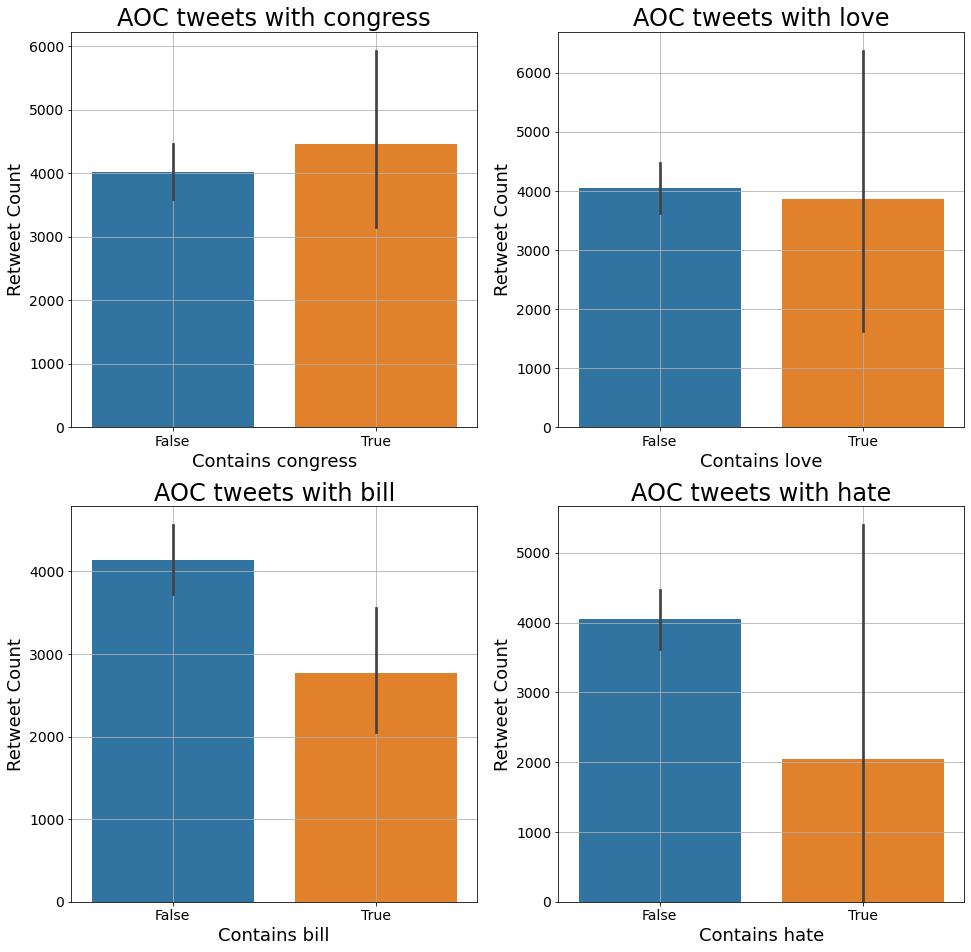

In [ ]:
fig = plt.figure(figsize = (16,16))

c=0
for keyword in keywords:
    c+=1
    plt.subplot(2,2,c)
    sns.barplot(data = df_u, x= f"keyword_{keyword}", 
                y = 'retweet_count', 
                errorbar=('ci', 95) )
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.ylabel("Retweet Count", fontsize = 18)
    plt.xlabel(f"Contains {keyword}", fontsize = 18)
    plt.title(f"{screen_name} tweets with {keyword}", fontsize = 24)
    plt.grid()
plt.show()

## Create Data for Statistical Tests

We will created to lists `X0` and `X1` that are the retweet counts without  and with a keyword.

In [ ]:
keyword = "love"

X0 = df_u.retweet_count[df_u[f"keyword_{keyword}"]==False].dropna().tolist()
X1 = df_u.retweet_count[df_u[f"keyword_{keyword}"]==True].dropna().tolist()
n0 = len(X0)
n1 = len(X1)

mu0 = np.mean(X0)
mu1 = np.mean(X1)

print(f"Tweets of {screen_name}")
print(f"Contains {keyword}\tNumber of tweets\tMean retweet count")
print(f"False\t\t{n0}\t\t\t{mu0:.3f}")
print(f"True\t\t{n1}\t\t\t{mu1:.3f}")

Tweets of AOC
Contains love	Number of tweets	Mean retweet count
False		1084			4042.836
True		15			3864.333


## Z-test

We will apply a z-test to see if the mean retweet count is different for tweets with and without the keyword.  We apply the `ztest` function to `X0` and `X1`.  We set `value=0` which means under the null hypothesis the means are equal.  The test returns the z-statistic `zstat` and the p-value `pval`.  We set the significance level `alpha` and if `pval<=alpha`, we can reject the null hypothesis.

In [ ]:
(zstat, pval) = ztest(X0, X1, value=0)


print(f"Z-test")
print(f"{keyword}: z-stat = {zstat:.3f} ({pval:.3f})\n")
alpha = 0.01  #significance level
if pval <=alpha:
  print("Significant at 1% level")
else:
  print("Not significant at 1% level")

Z-test
love: z-stat = 0.097 (0.922)

Not significant at 1% level


## T-test 

We can apply the t-test to compare the mean retweet counts.  The t-test is appropriate when the two groups have different variances.  We use the function `ttest_ind` and set `equal_var=False`.

In [ ]:
(tstat, pval) =stats.ttest_ind(X0,X1, equal_var = False)

print('T-test')
print(f"{keyword}: t-stat = {tstat:.3f} ({pval:.3f})\n")
alpha = 0.01  #significance level
if pval <=alpha:
  print("Significant at 1% level")
else:
  print("Not significant at 1% level")

T-test
love: t-stat = 0.138 (0.892)

Not significant at 1% level


## Mann-Whitney U test

The Mann-Whitney U test is a non-parametric test with the null hypothesis that the medians are equal.  We use the `mannwhitneyu` function.

In [ ]:
ustat, pval = stats.mannwhitneyu(X0, X1)

print('Mann Whitney U test')
print(f"{keyword}: U-stat = {ustat:.3f} ({pval:.3f})\n")
alpha = 0.01  #significance level
if pval <=alpha:
  print("Significant at 1% level")
else:
  print("Not significant at 1% level")

Mann Whitney U test
love: U-stat = 7717.500 (0.736)

Not significant at 1% level


## Kolmogorov-Smirnov test

The Kolmogorov-Smirnov test is a non-parametric test with the null hypothesis that the cumulative distribution functions of the two groups are equal.  We use the `ks_2samp` function.


In [ ]:
ksstat, pval = stats.ks_2samp(X0, X1)

print('Kolmogorov-Smirnov test')
print(f"{keyword}: KS-stat = {ustat:.3f} ({pval:.3f})\n")
alpha = 0.01  #significance level
if pval <=alpha:
  print("Significant at 1% level")
else:
  print("Not significant at 1% level")

Kolmogorov-Smirnov test
love: KS-stat = 7717.500 (0.810)

Not significant at 1% level


## Testing Multiple Hypotheses

If we test all the keywords to see which ones increase the mean retweet count, we need to correct the p-values to account for the multiple hypotheses.  We first calculate the p-value of a t-test for each keyword.  Then, we save these p-values in a list `pvals`.  Finally, we apply the `multipletests` function to `pvals` and set `method = 'holm'` to use the Holm-Bonferroni method.  We save the results in a dataframe `df_p` so we can read the results easily.

In [ ]:
pvals = []
for keyword in keywords:
  X0 = df_u.retweet_count[df_u[f"keyword_{keyword}"]==False].dropna().tolist()
  X1 = df_u.retweet_count[df_u[f"keyword_{keyword}"]==True].dropna().tolist()
  (tstat, pval) =stats.ttest_ind(X0,X1, equal_var = False)
  pvals.append(pval)
  print(f"{keyword}: t-stat = {tstat:.3f} ({pval:.4f})")



congress: t-stat = -0.573 (0.5682)
love: t-stat = 0.138 (0.8920)
bill: t-stat = 2.976 (0.0035)
hate: t-stat = 1.177 (0.3570)


In [ ]:
alpha = 0.01  #significance level
rejects,pvals_corrected,alphaSidak,alphacBonf = multipletests(pvals, alpha=alpha, 
                                                             method='holm', 
                                                             is_sorted=False, 
                                                             returnsorted=False)
df_p = pd.DataFrame({'keyword':keywords,
                     'reject_H0':rejects,
                     'pval corrected':pvals_corrected,
                     'pval':pvals})
print(f"Holm-Bonferroni method t-test")
df_p

Holm-Bonferroni method t-test


,keyword,reject_H0,pval corrected,pval
0,congress,False,1.000000,0.568246
1,love,False,1.000000,0.891972
2,bill,False,0.013958,0.003490
3,hate,False,1.000000,0.357050


# Comparing Users Language

We will look at two users and see if they use a given keyword with the same frequency.

## Contingency table

We select two users with screen names given by the variables `w0` and `w1` and we select a keyword `keyword`.  Then we calculate the contingency table for this data.  The table has the values `a`,`b`,`c`,`d` which indicate the number of tweets in each category as follows:

|Has keyword |User 0 | User 1|
|-|--------|------|
|True | a| b|
|False| c|d|

We store the table as a list of lists in `table`.

In [ ]:
w0 = 'elonmusk'
w1= 'AOC'

keyword ='love'


df0 =df_all[df_all.screen_name==w0]
df1 =df_all[df_all.screen_name==w1]

a = len(df0[df0.text.str.contains(keyword,  case=False)==True])
b = len(df1[df1.text.str.contains(keyword,  case=False)==True])
c = len(df0[df0.text.str.contains(keyword,  case=False)==False])
d = len(df1[df1.text.str.contains(keyword,  case=False)==False])

table = [[a, b], [c, d]]


print(f"Contingency Table for {keyword}")
print(f"Has {keyword}\t{w0}\t{w1}\nTrue\t{a}\t{b}\nFalse\t{c}\t{d}")



Contingency Table for love
Has love	elonmusk	AOC
True	1	15
False	99	1084


## Fisher Exact Test

We apply the Fisher exact test to the contingency table to see if the frequencies are different for the two users.  This is done with the `fisher_exact` function.

In [ ]:
oddsratio, pval = stats.fisher_exact(table,alternative='two-sided')

print('Fisher exact test')
print(f"{keyword}: odds ratio = {oddsratio:.3f} ({pval:.3f})\n")
alpha = 0.01  #significance level
if pval <=alpha:
  print("Significant at 1% level")
else:
  print("Not significant at 1% level")

Fisher exact test
love: odds ratio = 0.730 (1.000)

Not significant at 1% level


# Correlation Coefficient

We will look at the correlation of  sentiment with like count for a single user.

In [ ]:
screen_name = 'AOC'
df_u = df_all[df_all.screen_name==screen_name].copy()

## Pearson Correlation Coefficient

 We apply the `pearsonr` function to the like_count and sentiment columns of the dataframe.  The function returns the Pearson correlation coefficient `cc` and the p-value `pval`.  

In [ ]:
alpha = 0.01
cc,pval = stats.pearsonr(df_u.sentiment, df_u.like_count)

print(f"Pearson corr of sentiment and retweet count = {cc:.3f} ({pval:.3f})")
if pval <=alpha:
  print("Significant at 1% level")
else:
  print("Not significant at 1% level")

Pearson corr of sentiment and retweet count = -0.040 (0.183)
Not significant at 1% level


## Spearman Rank Correlation Coefficient

Spearman's rank correlation coefficient is a non-parametric correlation coefficient that is less susceptible to outliers because it considers the rank of the data, not its values.

In [ ]:
alpha = 0.01
cc,pval = stats.spearmanr(df_u.sentiment, df_u.like_count)

print(f"Spearman corr of sentiment and retweet count = {cc:.3f} ({pval:.3f})")
if pval <=alpha:
  print("Significant at 1% level")
else:
  print("Not significant at 1% level")

Spearman corr of sentiment and retweet count = 0.070 (0.020)
Not significant at 1% level


# Follower Engagement

Define follower engagement of a tweet as its retweet count divided by follower count.  This measures what fraction of a user's followers retweet their tweet.  We will compare the follower engagement for a pair of users.

## Load user profiles

The user profiles are in the table `users` in the file `"data/lecture_04"`.

In [ ]:
fname_db = "data/lecture_04"  #database filenmae
df_users = DB.fetch(table_name="users", path=fname_db)
df_users.rename(columns = {'username':'screen_name'}, inplace = True)

In [ ]:
df_all.screen_name.unique()

array(['elonmusk', 'dogecoin', 'kanyewest', 'KimKardashian',
       'MichelleObama', 'BarackObama', 'JBALVIN', nan, 'sanbenito', 'AOC',
       'KingJames', 'RashidaTlaib'], dtype=object)

## Calculate engagement

We choose two users with screen names `w0` and `w1`.  Then we calculate their tweet engagement and save the results to a dataframe `df_e`.

In [ ]:
w0 = "KimKardashian"
w1 = "kanyewest"
screen_names = [w0,w1]
Engagements = []
for screen_name in screen_names:
  f = df_users.followers_count[df_users.screen_name == screen_name]
  df_u  = df_all[df_all.screen_name==screen_name].copy()
  e = df_u.retweet_count/float(f)
  Engagements.append(e.tolist())
df_e = pd.DataFrame({'screen_name':screen_names, 'engagement':Engagements})


## T-test for engagement

In [ ]:
X0 = df_e.engagement[df_e.screen_name==w0].values[0]
X1 = df_e.engagement[df_e.screen_name==w1].values[0]

mu0 = np.mean(X0)
mu1 = np.mean(X1)

alpha = 0.01  #significance level
tstat, pval =stats.ttest_ind(X0,X1, equal_var = False)

print(f"Screen name\tMean engagement")
print(f"{w0}\t{mu0:e}")
print(f"{w1}\t{mu1:e}")

print(f"{w0} vs {w1}: t-stat = {tstat:.3f} ({pval:.4f})\n")
if pval <=alpha:
  print("Significant at 1% level")
else:
  print("Not significant at 1% level")

Screen name	Mean engagement
KimKardashian	1.229807e-05
kanyewest	1.916774e-04
KimKardashian vs kanyewest: t-stat = -9.640 (0.0000)

Significant at 1% level


# Tweet Time

We will study how the timing of a tweet affects like counts for a user

## Load data

In [ ]:
screen_name = 'AOC'
df_u = df_all[df_all.screen_name==screen_name].copy()

## Plot like count vs. hour

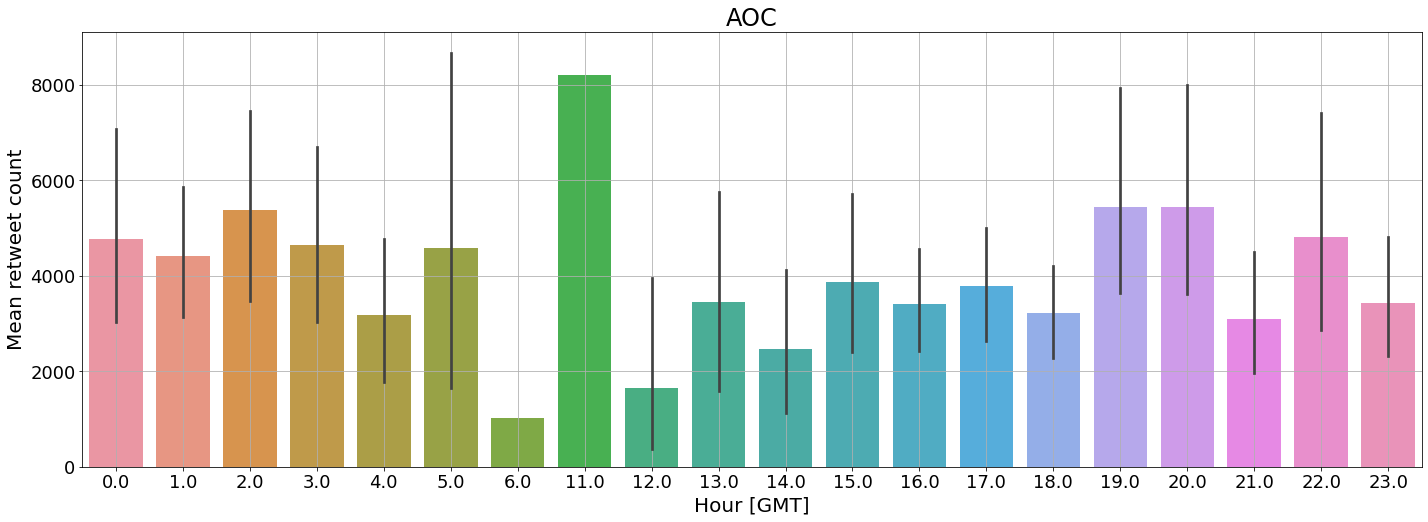

In [ ]:
fig = plt.figure(figsize =(24,8))
sns.barplot(data =df_u , x = 'hour', 
            y = 'retweet_count', 
            errorbar=('ci', 95))
plt.xlabel("Hour [GMT]", fontsize = 20)
plt.ylabel("Mean retweet count", fontsize = 20)
plt.title(f"{screen_name}", fontsize = 24)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.grid()
plt.show()

## T-test for hours

We select two hours and compare the retweet counts using a t-test

In [ ]:
w0 = 15
w1 = 3
X0 = df_u.retweet_count[df_u.hour==w0]
X1 = df_u.retweet_count[df_u.hour==w1]
mu0 = np.mean(X0)
mu1 = np.mean(X1)
(tstat, pval) =stats.ttest_ind(X0,X1, equal_var = False)

print(f"Hour [GMT]\tMean retweet count")
print(f"{w0}\t{mu0:.2f}")
print(f"{w1}\t{mu1:.2f}")
print(f"{w0} vs {w1}: t-stat = {tstat:.3f} ({pval:.4f})\n")
alpha = 0.01  #significance level
if pval <=alpha:
  print("Significant at 1% level")
else:
  print("Not significant at 1% level")

Hour [GMT]	Mean retweet count
15	3866.69
3	4641.55
15 vs 3: t-stat = -0.594 (0.5543)

Not significant at 1% level


## T-test for day vs night

We can choose a range of hours to compare daytime and nighttime tweets' retweet counts.

In [ ]:
#daytime
X0 = df_u.retweet_count[(12<=df_u.hour) & (df_u.hour<23)]
#nighttime
X1 = df_u.retweet_count[(0<=df_u.hour) & (df_u.hour<12)]

mu0 = np.mean(X0)
mu1 = np.mean(X1)
(tstat, pval) =stats.ttest_ind(X0,X1, equal_var = False)

print(f"Hour [GMT]\tMean retweet count")
print(f"Day\t{mu0:.2f}")
print(f"Night\t{mu1:.2f}")
print(f"{w0} vs {w1}: t-stat = {tstat:.3f} ({pval:.4f})\n")
alpha = 0.01  #significance level
if pval <=alpha:
  print("Significant at 1% level")
else:
  print("Not significant at 1% level")

Hour [GMT]	Mean retweet count
Day	3916.28
Night	4598.05
15 vs 3: t-stat = -1.374 (0.1701)

Not significant at 1% level
